In [11]:
import torch
import torch_geometric
import torch_geometric.transforms as T
from glob import glob
import xarray as xr
import pandas as pd
import matplotlib as plt
import datetime

In [12]:
torch.cuda.is_available()

False

In [28]:
class ssp_data():
    def __init__(self, n=39) -> None:
        self.n = n
        self.raw = {}
        self.init_edge_list(n)
        self.y_file = 'data\\tas_scenario_245\\tas_mon_mod_ssp245_192_000.nc'
        self.x_file_list = [item for item in glob('data\\tas_scenario_245\\tas_mon_mod_ssp245_192_*.nc') if item not in [self.y_file]][0 : self.n]
        self.create_df()
        # self.x_tensor = self.create_tensors(self.x).T
        # self.y_tensor = self.create_tensors(self.y)
        # self.data = torch_geometric.data.Data(x=self.x_tensor, edge_index=self.edge_index.t().contiguous(), y=self.y_tensor)
        # self.split_data()
        # self.mini_graphs()

    def init_edge_list(self, n):
        self.edge_index = []
        for i in range(n):
            for j in range(n):
                if i != j:
                    self.edge_index.append([i, j])
        self.edge_index = torch.tensor(self.edge_index, dtype=torch.long)

    def create_df(self):
        self.x = pd.DataFrame()
        i = 1
        for filename in self.x_file_list:
            print('Processing', filename)
            self.x[f'model_{i}'] = self.create_vector(filename)
            i += 1
        
        self.y = self.create_vector(self.y_file)

    def create_vector(self, filename):
        data = xr.open_dataset(filename)
        df = data.to_dataframe().reset_index()
        self.raw[filename] = df
        df['date'] = pd.to_datetime(df['time'], errors='coerce')
        tas_vector = df.loc[(df['date'].dt.year >= 1960) & (df['date'].dt.year <= 1970), 'tas']#['tas']#[0:5000]
        # print(tas_vector)
        return tas_vector
    
    def get_device(self):
        if torch.cuda.is_available():
            device = torch.device('cuda:0')
        else:
            device = torch.device('cpu') # don't have GPU 
        return device

    def create_tensors(self, df):
        device = self.get_device()
        return torch.from_numpy(df.values).float().to(device)
    
    def mini_graphs(self):
        df = self.x
        df['x_tensor'] = df.apply(lambda row: torch.tensor(row.values.flatten()), axis=1)
        df['y'] = self.y
        df['y_tensor'] = df['y'].apply(lambda y: torch.tensor(y))
        df['data_obj'] = df.apply(lambda row: torch_geometric.data.Data(x=df['x_tensor'], edge_index=self.edge_index.t().contiguous(), y=df['y_tensor']), axis=1)
        self.batch_graphs = df['data_obj']
    
    def split_data(self):
        transform = T.Compose([T.RandomNodeSplit(num_test=1000, num_val=1000)])
        self.data = transform(self.data) 


In [29]:
ssp_data = ssp_data(n=2)

Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_001.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_002.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_003.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_004.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_005.nc


In [30]:
ssp_data.raw

{'data\\tas_scenario_245\\tas_mon_mod_ssp245_192_001.nc':              lat      lon                time  height         tas  \
 0        -89.375    0.000 1850-01-16 12:00:00     2.0  243.845352   
 1        -89.375    0.000 1850-02-15 00:00:00     2.0  235.352936   
 2        -89.375    0.000 1850-03-16 12:00:00     2.0  223.914154   
 3        -89.375    0.000 1850-04-16 00:00:00     2.0  220.158920   
 4        -89.375    0.000 1850-05-16 12:00:00     2.0  217.610214   
 ...          ...      ...                 ...     ...         ...   
 83275771  89.375  358.125 2100-08-16 12:00:00     2.0  271.679413   
 83275772  89.375  358.125 2100-09-16 00:00:00     2.0  272.342682   
 83275773  89.375  358.125 2100-10-16 12:00:00     2.0  272.067474   
 83275774  89.375  358.125 2100-11-16 00:00:00     2.0  270.890015   
 83275775  89.375  358.125 2100-12-16 12:00:00     2.0  265.080322   
 
                         date  
 0        1850-01-16 12:00:00  
 1        1850-02-15 00:00:00  
 2   

<Axes: >

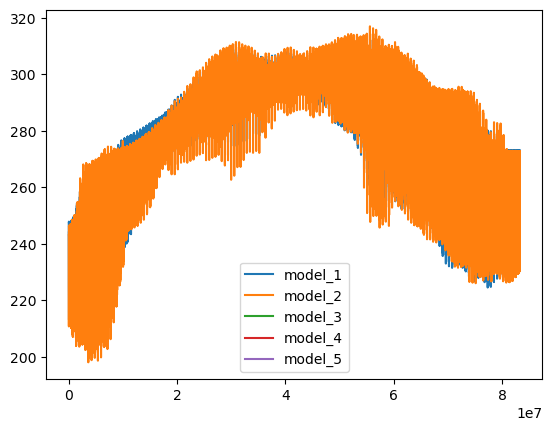

In [26]:
ssp_data.x.plot()

In [85]:
ssp_data.data.validate()

True

In [86]:
ssp_data.data

Data(x=[39, 5000], edge_index=[2, 1482], y=[5000], train_mask=[39], val_mask=[39], test_mask=[39])

In [87]:
ssp_data.data.num_node_features

5000

In [88]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.edge_weight = torch.nn.Parameter(torch.ones(ssp_data.data.num_edges))
        self.conv1 = GCNConv(ssp_data.data.num_node_features, 16)
        self.conv2 = GCNConv(16, 5000)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)#, torch.minimum(self.edge_weight.abs(),torch.ones(data.num_edges)))
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        # print(x, edge_index, torch.minimum(self.edge_weight.abs(),torch.ones(data.num_edges)))
        x = self.conv2(x, edge_index)#, torch.minimum(self.edge_weight.abs(),torch.ones(data.num_edges)))

        return x


In [89]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = ssp_data.data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    print(epoch, loss)
    loss.backward()
    optimizer.step()

C:\Users\jqcla\AppData\Local\Temp\ipykernel_8980\3691684479.py:11: UserWarning: Using a target size (torch.Size([5000])) that is different to the input size (torch.Size([39, 5000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, data.y)


0 tensor(nan, grad_fn=<MseLossBackward0>)
1 tensor(nan, grad_fn=<MseLossBackward0>)
2 tensor(nan, grad_fn=<MseLossBackward0>)
3 tensor(nan, grad_fn=<MseLossBackward0>)
4 tensor(nan, grad_fn=<MseLossBackward0>)
5 tensor(nan, grad_fn=<MseLossBackward0>)
6 tensor(nan, grad_fn=<MseLossBackward0>)
7 tensor(nan, grad_fn=<MseLossBackward0>)
8 tensor(nan, grad_fn=<MseLossBackward0>)
9 tensor(nan, grad_fn=<MseLossBackward0>)
10 tensor(nan, grad_fn=<MseLossBackward0>)
11 tensor(nan, grad_fn=<MseLossBackward0>)
12 tensor(nan, grad_fn=<MseLossBackward0>)
13 tensor(nan, grad_fn=<MseLossBackward0>)
14 tensor(nan, grad_fn=<MseLossBackward0>)
15 tensor(nan, grad_fn=<MseLossBackward0>)
16 tensor(nan, grad_fn=<MseLossBackward0>)
17 tensor(nan, grad_fn=<MseLossBackward0>)
18 tensor(nan, grad_fn=<MseLossBackward0>)
19 tensor(nan, grad_fn=<MseLossBackward0>)
20 tensor(nan, grad_fn=<MseLossBackward0>)
21 tensor(nan, grad_fn=<MseLossBackward0>)
22 tensor(nan, grad_fn=<MseLossBackward0>)
23 tensor(nan, grad_f

In [90]:
model.eval()
out = model(data)
mse = F.mse_loss(out, data.y)
print(f'MSE: {mse:.4f}')

MSE: nan


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8980\121057100.py:3: UserWarning: Using a target size (torch.Size([5000])) that is different to the input size (torch.Size([39, 5000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(out, data.y)


In [92]:
model.__dir__

<bound method Module.__dir__ of GCN(
  (conv1): GCNConv(5000, 16)
  (conv2): GCNConv(16, 5000)
)>